Dataset link: 
[Obfuscated JavaScript dataset](https://github.com/PacktPublishing/Machine-Learning-for-Cybersecurity-Cookbook/tree/master/Chapter03/Detecting%20Obfuscated%20Javascript)

In [1]:
import os
import re
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import Counter
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score

warnings.filterwarnings('ignore')
sns.set_theme(font_scale = 2)

SEED = 0
JS_DATA_DIR = "./JavascriptSamples"
OBFUSCATED_JS_DATA_DIR = "./JavascriptSamplesObfuscated"

# Data loading

In [2]:
filenames, scripts, labels = [], [], []
file_types_and_labels = [(JS_DATA_DIR, 0), (OBFUSCATED_JS_DATA_DIR, 1)]

for files_path, label in file_types_and_labels:
    files = os.listdir(files_path)
    for file in tqdm(files):
        file_path = files_path + "/" + file
        try:
            with open(file_path, "r", encoding="utf8") as myfile:
                df = myfile.read().replace("\n", "")
                df = str(df)
                filenames.append(file)
                scripts.append(df)
                labels.append(label)
        except Exception as e:
            print(e)

100%|████████████████████████████████████| 1477/1477 [00:00<00:00, 50150.87it/s]


In [3]:
df = pd.DataFrame(data=filenames, columns=['js_filename'])
df['js'] = scripts
df['label'] = labels

df.head()

,js_filename,js,label
0,sitemap.js,'use strict';var exclusionRegex = /^index|exam...,0
1,test-make-doc.js,'use strict';const common = require('../common...,0
2,test-crypto-pbkdf2.js,'use strict';const common = require('../common...,0
3,ngSwipe-obfuscated.js,"var a29_0x2b31=['mouse','bind','$apply','trigg...",0
4,test-code-cache-generator.js,'use strict';// This test verifies that the bi...,0


# Cleansing

In [4]:
# removing empty scripts
df = df[df['js'] != '']

# removing duplicates
df = df[~df["js"].isin(df["js"][df["js"].duplicated()])]

# Some obfuscated scripts I found in the legitimate JS samples folder, so let's change it label to 1
df["label"][df["js_filename"].apply(lambda x: True if 'obfuscated' in x else False)] = 1

In [5]:
df.label.value_counts()

0    1847
1    1515
Name: label, dtype: int64

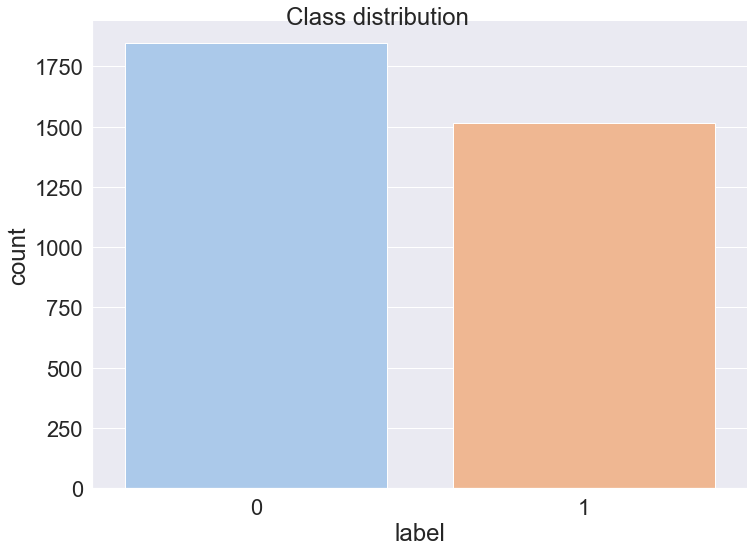

In [6]:
ax = sns.catplot("label",
                data=df,
                kind="count",
                palette="pastel",
                legend=False, 
                height=8, 
                aspect=11/8)

ax.fig.suptitle("Class distribution",
                fontsize=24, 
                fontdict={"weight": "bold"});

# Featurization

In [7]:
df['js_length'] = df.js.apply(lambda x: len(x))
df['num_spaces'] = df.js.apply(lambda x: x.count(' '))

df['num_parenthesis'] = df.js.apply(lambda x: (x.count('(') + x.count(')')))
df['num_slash'] = df.js.apply(lambda x: x.count('/'))
df['num_plus'] = df.js.apply(lambda x: x.count('+'))
df['num_point'] = df.js.apply(lambda x: x.count('.'))
df['num_comma'] = df.js.apply(lambda x: x.count(','))
df['num_semicolon'] = df.js.apply(lambda x: x.count(';'))
df['num_alpha'] = df.js.apply(lambda x: len(re.findall(re.compile(r"\w"),x)))
df['num_numeric'] = df.js.apply(lambda x: len(re.findall(re.compile(r"[0-9]"),x)))

df['ratio_spaces'] = df['num_spaces'] / df['js_length']
df['ratio_alpha'] = df['num_alpha'] / df['js_length']
df['ratio_numeric'] = df['num_numeric'] / df['js_length']
df['ratio_parenthesis'] = df['num_parenthesis'] / df['js_length']
df['ratio_slash'] = df['num_slash'] / df['js_length']
df['ratio_plus'] = df['num_plus'] / df['js_length']
df['ratio_point'] = df['num_point'] / df['js_length']
df['ratio_comma'] = df['num_comma'] / df['js_length']
df['ratio_semicolon'] = df['num_semicolon'] / df['js_length']

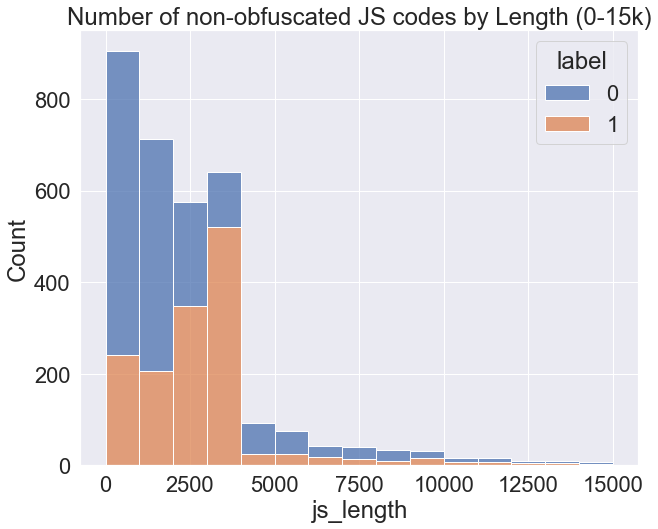

In [8]:
plt.figure(figsize=(10, 8))

sns.histplot(data=df,
             x='js_length', 
             stat='count', 
             hue='label', 
             multiple='stack', 
             bins=[0,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000])

plt.title('Number of non-obfuscated JS codes by Length (0-15k)')
plt.show();

In [9]:
def entropy(s):
    p, lns = Counter(s), float(len(s))
    return -sum( count/lns * math.log(count/lns, 2) for count in p.values())

df['entropy'] = df.js.apply(lambda x: entropy(x))

print("Mean entropy for obfuscated js:", df['entropy'][df["label"] == 1].mean())
print("Mean entropy for non-obfuscated js:", df['entropy'][df["label"] == 0].mean())

Mean entropy for obfuscated js: 5.28466722011188
Mean entropy for non-obfuscated js: 4.807257806119003


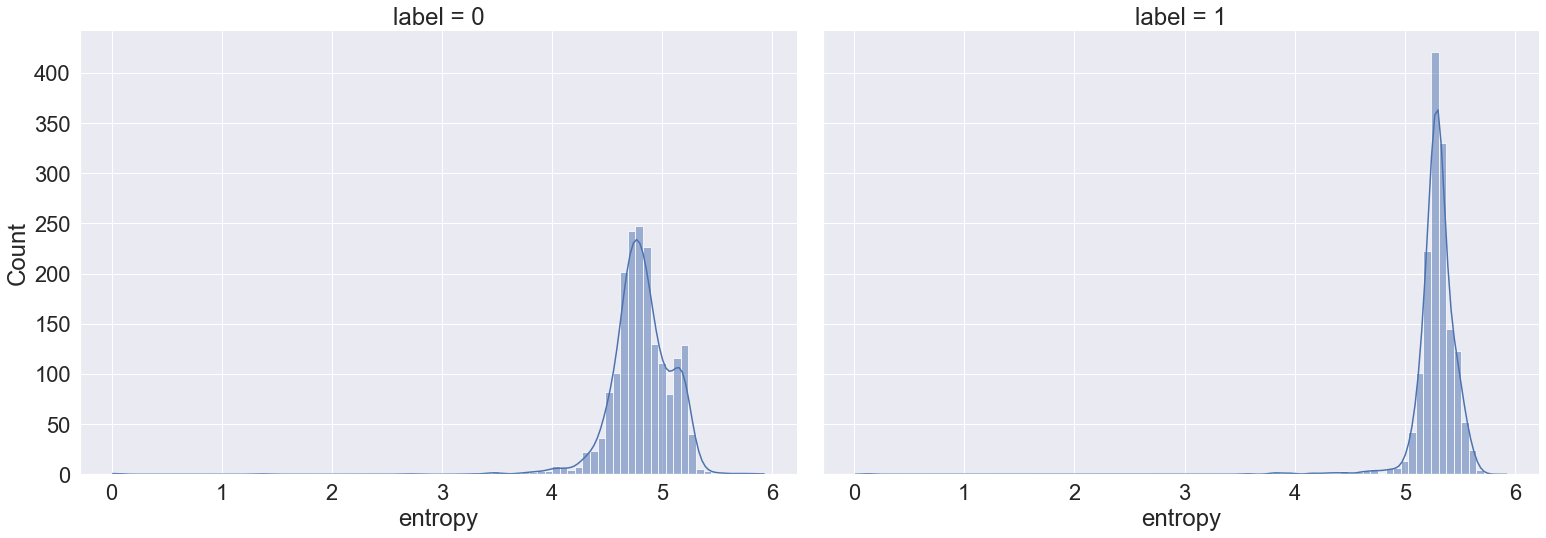

In [10]:
sns.displot(data=df, 
            x="entropy", 
            col="label", 
            kde=True, 
            palette="pastel",
            height=8, 
            aspect=11/8);

In [11]:
# String Operation: substring(), charAt(), split(), concat(), slice(), substr()

df['num_string_oper'] = df.js.apply(lambda x: x.count('substring') + 
                                            x.count('charAt') + 
                                            x.count('split') +
                                            x.count('concat') +
                                            x.count('slice') +
                                            x.count('substr'))

df['ratio_num_string_oper'] = df['num_string_oper'] / df['js_length']

print("Mean string operations for obfuscated js:", df['num_string_oper'][df["label"] == 1].mean())
print("Mean string operations for non-obfuscated js:", df['num_string_oper'][df["label"] == 0].mean())

Mean string operations for obfuscated js: 0.2706270627062706
Mean string operations for non-obfuscated js: 0.8955062263129399


In [12]:
# Encoding Operation: escape(), unescape(), string(), fromCharCode()

df['num_encoding_oper'] = df.js.apply(lambda x: x.count('escape') +
                                        x.count('unescape') +
                                        x.count('string') +
                                        x.count('fromCharCode'))

df['ratio_num_encoding_oper'] = df['num_encoding_oper'] / df['js_length']

print("Mean encoding operations for obfuscated js:", df['num_encoding_oper'][df["label"] == 1].mean())
print("Mean encoding operations for non-obfuscated js:", df['num_encoding_oper'][df["label"] == 0].mean())

Mean encoding operations for obfuscated js: 0.39801980198019804
Mean encoding operations for non-obfuscated js: 1.5489983757444505


In [13]:
# URL Redirection: setTimeout(), location.reload(), location.replace(), document.URL(), document.location(), document.referrer()

df['num_url_redirection'] = df.js.apply(lambda x: x.count('setTimeout') +
                                          x.count('location.reload') +
                                          x.count('location.replace') +
                                          x.count('document.URL') +
                                          x.count('document.location') +
                                          x.count('document.referrer'))

df['ratio_num_url_redirection'] = df['num_url_redirection'] / df['js_length']

print("Mean URL redirections for obfuscated js:", df['num_url_redirection'][df["label"] == 1].mean())
print("Mean URL redirections for non-obfuscated js:", df['num_url_redirection'][df["label"] == 0].mean())

Mean URL redirections for obfuscated js: 0.04884488448844884
Mean URL redirections for non-obfuscated js: 0.21548456957227938


In [14]:
# Specific Behaviors: eval(), setTime(), setInterval(), ActiveXObject(), createElement(), document.write(), document.writeln(), document.replaceChildren()

df['num_specific_func'] = df.js.apply(lambda x: x.count('eval') +
                                       x.count('setTime') +
                                       x.count('setInterval') +
                                       x.count('ActiveXObject') +
                                       x.count('createElement') +
                                       x.count('document.write') +
                                       x.count('document.writeln') +
                                       x.count('document.replaceChildren'))

df['ratio_num_specific_func'] = df['num_specific_func'] / df['js_length']

print("Mean specific functions for obfuscated js:", df['num_specific_func'][df["label"] == 1].mean())
print("Mean specific functions for non-obfuscated js:", df['num_specific_func'][df["label"] == 0].mean())

Mean specific functions for obfuscated js: 0.18943894389438945
Mean specific functions for non-obfuscated js: 0.7855982674607471


# Random Forest

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 3:], df['label'],
                                                    stratify=df['label'], 
                                                    test_size=0.2,
                                                    random_state=SEED)

In [16]:
clf = RandomForestClassifier(n_estimators=100, random_state=SEED)

# 5-Fold Cross validation
print("Mean accuracy over 5 folds:", np.mean(cross_val_score(clf, X_train, y_train, cv=5)))

Mean accuracy over 5 folds: 0.9907014738357803


In [17]:
clf=RandomForestClassifier(n_estimators=100, random_state=SEED)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.986627043090639


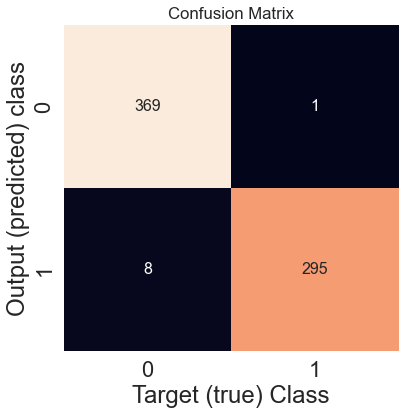

               precision    recall  f1-score   support

non-obfuscted       0.98      1.00      0.99       370
   obfuscated       1.00      0.97      0.98       303

     accuracy                           0.99       673
    macro avg       0.99      0.99      0.99       673
 weighted avg       0.99      0.99      0.99       673



In [18]:
conf_mat = metrics.confusion_matrix(y_test, y_pred)

plt.subplots(figsize=(6,6))
sns.set(font_scale=1.4) # for label size
sns.heatmap(conf_mat, annot=True, fmt=".0f", annot_kws={"size": 16}, cbar=False) # font size
plt.xlabel('Target (true) Class'); plt.ylabel('Output (predicted) class'); plt.title('Confusion Matrix')
plt.show();

print(metrics.classification_report(y_test,
                                    y_pred,
                                    target_names=['non-obfuscted', 'obfuscated']))

<center>* * *<center>